In [86]:
import pandas as pd
import numpy as np
import nltk
import time
import matplotlib.pyplot as plt
import seaborn as sns
import os, glob
import csv
from functools import reduce
import re
import string

In [128]:
import numpy as np
labels = ["Direct Harassment", "Hate Speech","Sexual Harassment","Trolling", "Others", "Toxic"]

batch_files = ['usanews.csv', 'foxnews0.csv', 'foxnews1.csv', 'foxnews2.csv', 'foxnews3.csv', 
                'nogla0.csv','pew0.csv', 'rae0_0.csv', 
                 'rae0_1.csv', 'terror0_0.csv', 'terror0_1.csv']

vid_files = ["foxnews_FULL.csv", "rae_FULL.csv",  "terror_FULL.csv",
             "usanews.csv" , "pew0.csv", "nogla0.csv", "drdisrespect_FULL.csv"]
genre_files = ["gaming_channels_GENRE.csv", "news_channel_GENRE.csv" ]

files = []
files.extend(vid_files)
files.extend(genre_files)
print(files)


['foxnews_FULL.csv', 'rae_FULL.csv', 'terror_FULL.csv', 'usanews.csv', 'pew0.csv', 'nogla0.csv', 'drdisrespect_FULL.csv', 'gaming_channels_GENRE.csv', 'news_channel_GENRE.csv']


In [129]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
# Download stopwords list
nltk.download('punkt')
stop_words = stopwords.words('english')
news_StopWords = ['joe','biden', 'trump', 'lady', 'gaga', 'kamala', 'harris', 'nancy', 'pelosi', 'nogla', 'pewdiepie', 'obama', 'felix', 
                   'bidens','brian','tom', '2020','corpse','sunny', 'yu','ivanka', 'camela', 'debbie', 'gets', 'could',
                  'go','get','use','say','look','would','first','well','okay','see','floyd','pete','terroriser','finally', 'austria',
                  'george','china', 'america','want','one', 'castillo','toast','turkey','beijing', 'noah','cory', 'dosent', 
                  '130', '15', 'tiktok','many','enough', 'currently', 'united','everytime', 'many',
                  'even','whoever','never','usa','think','behind', 'make','need','50','21','vote','cnn','back','discord','nothing',
                 'jack','know','come','big', 'sanchez', 'greta', 'anyone', 'nothing', 'everyone', 'netherlands','soon', 'sometime']
stop_words.extend(news_StopWords)

def get_tfidf_vect(documents, a, b):
    vectorizer = TfidfVectorizer(ngram_range=(a,b),
                                 max_df=0.85, analyzer = 'word', min_df=1, max_features=5000, 
                                 stop_words=stop_words, lowercase=True)
    vector = vectorizer.fit_transform(documents)
    feature_names = np.array(vectorizer.get_feature_names())
    return pd.DataFrame(vector.todense(), columns=feature_names), vector, feature_names

def get_combined_tfidf_values_per_label(tfidf_df):
    combined_tfidf = pd.DataFrame(columns= (list(features) + labels))
    for label in labels:
        combined_scores = tfidf_df[tfidf_df[label] == 1][features].sum()
        to_append = list(combined_scores) + [0,0,0,0,0,0]
        row = pd.Series(to_append, index = (list(features) + labels))
        combined_tfidf = combined_tfidf.append(row, ignore_index=True)
        combined_tfidf.loc[combined_tfidf.index[-1],label] = 1.0
    return combined_tfidf

def get_combined_tfidf_values_per_label_only(tfidf_df):
    combined_tfidf = pd.DataFrame(columns= (list(features) + labels))
    for label in labels:
        combined_scores = tfidf_df[ (tfidf_df[label] == 1) & (tfidf_df["Toxic"] == 0) ][features].sum()
        to_append = list(combined_scores) + [0,0,0,0,0,0]
        row = pd.Series(to_append, index = (list(features) + labels))
        combined_tfidf = combined_tfidf.append(row, ignore_index=True)
        combined_tfidf.loc[combined_tfidf.index[-1],label] = 1.0
    return combined_tfidf

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Phoebe\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [130]:
from scipy.stats import spearmanr
def get_corr_vals(df):
    features = df.columns.difference(labels)
    pvals = {}
    spm = {}
    for label in labels:
        p_values = {}
        sp_coeff = {}
        for f in features:
            #print(f)
            sp, pval = spearmanr(df[label], df[f])
            p_values[f] = pval
            sp_coeff[f] = sp
        pvals[label + " p-val"] = p_values
        spm[label] = sp_coeff
        
        x = pd.DataFrame.from_dict(pvals)
        y = pd.DataFrame.from_dict(spm)
        z = pd.concat([x,y], axis=1)
        z = z.reindex(sorted(z.columns), axis=1)
    return z

In [131]:
src_folder = "../Annotations/CSVs/"
dest_folder = "tfidf_scores_WORDS_per_video_2/"

for file in genre_files:
    #read file
    df = pd.read_csv(src_folder + file, index_col = 0)
    #get words
    df["words"] = df["words"].replace(np.nan, '', regex=True)
    
    #tfidf of words
    tfidf_df, vector, features = get_tfidf_vect(df['words'], 1,2)
    tfidf_df[labels] = df[labels] #add tthe labels
    tfidf_df.to_csv(dest_folder + file)
    #combine tfidf values per label
    combined_tfidf = get_combined_tfidf_values_per_label(tfidf_df)
    combined_tfidf.to_csv(dest_folder + "LABEL" + file)

C:\Users\Phoebe\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3418: DtypeWarning: Columns (11,12,14,17) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [132]:
src_folder = "tfidf_scores_WORDS_per_video_2/LABEL"
dest_folder = "tfidf_scores_WORDS_per_video_2/"
top_dfs = []
for file in genre_files:
    vals = {}
    df = pd.read_csv(src_folder+file, index_col = 0)
    features = df.columns.difference(labels)
    dfs = []
    for label in labels:
        dl = df[df[label] == 1][features]
        dl = dl.T.sort_values(by=[dl.T.columns[0]], ascending = False)
        dl.index.name = "".join([w[0] for w in label.split()])
        if label == "Trolling":
            dl.index.name += "R"
        elif label == "Toxic":
            dl.index.name += "X"
        elif label == "Others":
            dl.index.name += "T"
        dl = dl.rename({dl.columns[0]:  dl.index.name + " value"}, axis='columns')
        dl.index.name += " words"
        dfs.append(dl)
    dfs = [d.reset_index(drop=False) for d in dfs]
    x = pd.concat(dfs, axis=1)
    display(x.head(50))   
    x.to_csv(dest_folder+"TOP_WORDS_"+file)

DH words  DH value              HS words   HS value  \
0           suck  3.143573                   blm  71.008469   
1         racist  2.000000              blm joke   5.914836   
2            gay  2.000000                  joke   5.291633   
3           like  1.741239                 black   4.770098   
4       annoying  1.440424                 death   3.445344   
5          smell  1.389295             black guy   3.400299   
6     always die  1.283172             death blm   2.670173   
7            die  1.225110                racist   2.605182   
8            bad  1.182973                   guy   2.550981   
9           poor  1.169426            blm racist   2.172984   
10          dude  1.161493                matter   2.118477   
11          game  1.059471                  hate   2.067519   
12         trash  1.000000          lives matter   1.774664   
13          noob  1.000000                 lives   1.764369   
14      hahahaha  1.000000                  blue   1.425178   
15        boring  1.000000                  suck   1.344499   
16           bro  1.000000                   gay   1.235472   
17        stupid  1.000000              blm suck   1.142924   
18          kill  1.000000                  care   1.074622   
19       fucking  1.000000                 white   1.000133   
20         smoke  1.000000                  hell   1.000000   
21        cringe  1.000000                    bl   1.000000   
22        always  0.900306  blacklivesdontmatter   1.000000   
23         spoil  0.846684                  fblm   1.000000   
24        chance  0.839553                   cop   0.919997   
25           mom  0.828195                  like   0.899090   
26   jamesablaze  0.808818           blue haired   0.872496   
27           hes  0.775256                haired   0.853066   
28          seem  0.762089           life matter   0.847256   
29            ka  0.759836                murder   0.837375   
30          luck  0.750974                stupid   0.812327   
31     lightning  0.750618            care black   0.812141   
32          hole  0.749764                 trash   0.793309   
33          yell  0.742482                  life   0.785890   
34          ever  0.741734                  dead   0.778024   
35        fuckin  0.741002               blm sus   0.758414   
36         dirty  0.719352             blm toxic   0.735115   
37          sooo  0.694646             white guy   0.722805   
38         nasty  0.682033               dislike   0.718220   
39     die round  0.672027               fck blm   0.684825   
40         idiot  0.671503                  jews   0.673727   
41          dumb  0.669866                aussie   0.672932   
42          vibe  0.668714                 color   0.654037   
43          care  0.660737             terrorist   0.649270   
44        speedy  0.660496         blm terrorist   0.649270   
45          haha  0.660332                  fill   0.636771   
46          foot  0.657973                   fck   0.619661   
47         shout  0.650115             white boy   0.614107   
48  stream snipe  0.649518                  yumi   0.608819   
49         video  0.647472                   nlm   0.596168   

                              SH words  SH value           TR words  TR value  \
0                                 dick  3.350605    charity members  4.613767   
1                                  gay  1.616831  donations charity  4.613767   
2                                thicc  1.419905          donations  4.613767   
3                                  fan  1.000000      members money  4.613767   
4                                 hurt  0.832255            members  4.519881   
5                                 sexy  0.724195            charity  4.502822   
6                                   jk  0.714852              money  4.260034   
7                                  doe  0.707107            dislike  1.434246   
8                                booty  0.701370               jo

DH words   DH value    HS words   HS value       SH words  SH value  \
0           suck  18.681195   democrats  21.260879            gag  5.000000   
1         prison  11.097392   socialism  20.738978          bitch  1.481959   
2           jail   9.225989        suck  16.596187           wife  1.305549   
3          loser   7.524821      prison  12.818211            man  1.270289   
4           lock   6.988974   communist  12.502160       kameltoe  1.165130   
5            cry   6.907238      people  12.024788          woman  1.026577   
6         sleepy   6.610568      racist  10.374505         really  1.000000   
7        corrupt   6.506905       black   9.866435      beautiful  1.000000   
8            lol   6.500537       idiot   9.531608           hell  0.851064   
9           liar   5.352904        dems   9.128950          hairy  0.788588   
10         idiot   5.184179       virus   8.044873        husband  0.714051   
11        family   5.088909         blm   7.937863        shitmer  0.700094   
12        pardon   5.045200      matter   7.912996           host  0.699217   
13        racist   4.973252         dem   7.886880           shut  0.687040   
14          hate   4.898201     corrupt   7.778451         energy  0.681969   
15           lie   4.810812        hate   7.700488         commie  0.655334   
16          joke   4.689635       moron   7.645937         mother  0.652561   
17        stupid   4.651349     chinese   7.112568  hell kameltoe  0.651069   
18         trash   4.576469   president   7.055688      show tape  0.620645   
19         crime   4.515077        jail   6.954470           tape  0.603346   
20          like   4.434119          ðÿ   6.849031          loser  0.562442   
21        people   4.228995       trash   6.445811         period  0.536775   
22          home   4.219685         win   6.046162     difference  0.518740   
23  crime family   4.176393     country   5.714386     buck fiden  0.514114   
24        commie   4.065288       cheat   5.213027            fan  0.511842   
25       crooked   3.989907        like   5.195221          fiden  0.506478   
26           man   3.905549        left   5.044453           show  0.500773   
27          shit   3.898675   socialist   5.029604           call  0.494465   
28     communist   3.875371  republican   5.014137       dementia  0.494203   
29           bye   3.848148       world   5.000891           buck  0.493719   
30         frack   3.681463       party   4.992950             tv  0.483290   
31     president   3.680314        life   4.989094          nasty  0.483290   
32          take   3.653708     destroy   4.800624            due  0.479906   
33       traitor   3.615129        love   4.761217        suck ðÿ  0.468604   
34          lose   3.496225        news   4.698428      ðÿ choice  0.468604   
35          dead   3.482876     liberal   4.693587           view  0.465736   
36          fool   3.467635         rid   4.692805        website  0.464809   
37          show   3.438495         red   4.511833       industry  0.458628   
38         watch   3.413176    democrat   4.413045       man suck  0.451700   
39          news   3.363060        dead   4.408841            new  0.441310   
40          maga   3.358926      commie   4.358759       campaign  0.432302   
41          hell   3.331737         pay   4.329612           talk  0.398815   
42       country   3.139420        lock   4.120188          video  0.395447   
43          lmao   3.041046         war   4.094163           fire  0.382743   
44       destroy   3.016632     marxist   4.086752           real  0.376261   
45          life   3.002848        anti   4.048276         choice  0.370842   
46         moron   3.000000     traitor   4.004115          watch  0.350696   
47     supporter   2.998747        fake   3.997747           suck  0.326265   
48          sell   2.971043       troll   3.974620         hunter  0.314986   
49          bald   2.874415        save   3.969579        

gaming_channels_GENRE.csv
Direct Harassment


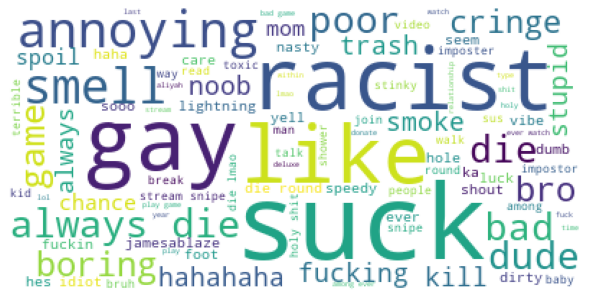

Hate Speech


<Figure size 432x288 with 0 Axes>

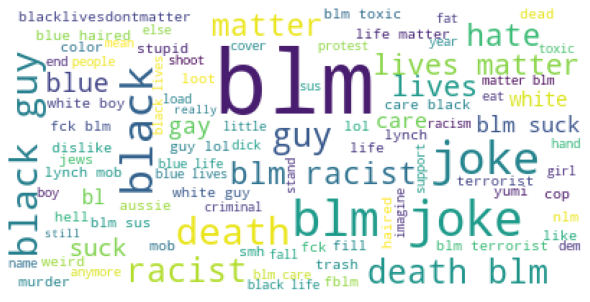

Sexual Harassment


<Figure size 432x288 with 0 Axes>

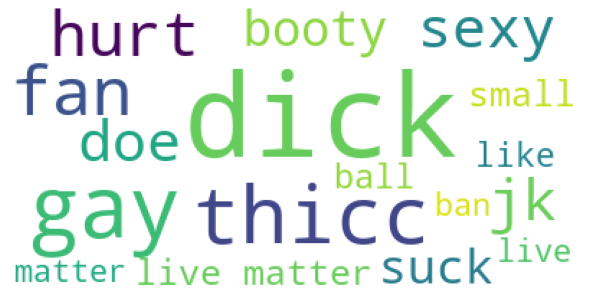

Trolling


<Figure size 432x288 with 0 Axes>

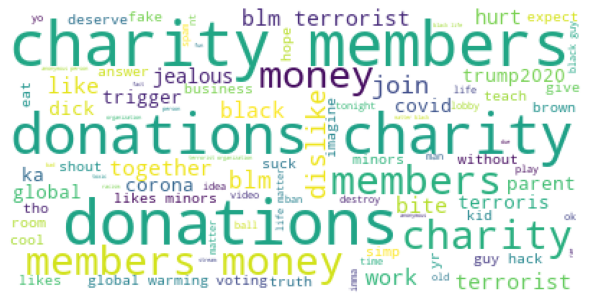

Others


<Figure size 432x288 with 0 Axes>

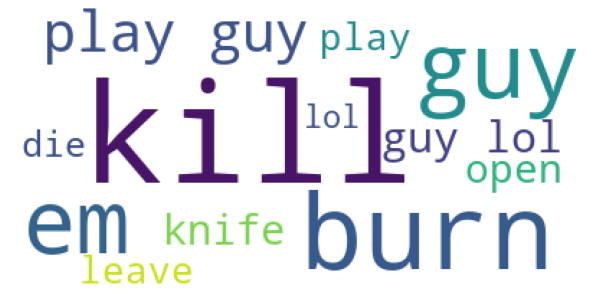

Toxic


<Figure size 432x288 with 0 Axes>

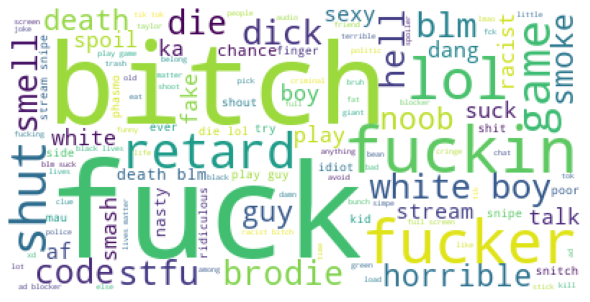

news_channel_GENRE.csv
Direct Harassment


<Figure size 432x288 with 0 Axes>

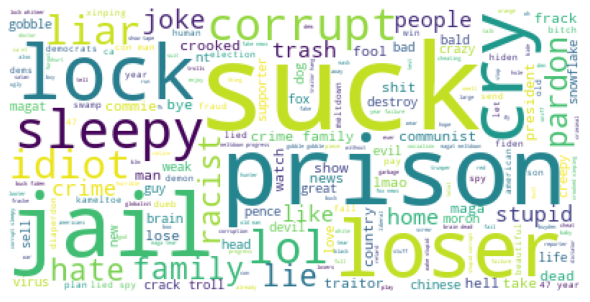

Hate Speech


<Figure size 432x288 with 0 Axes>

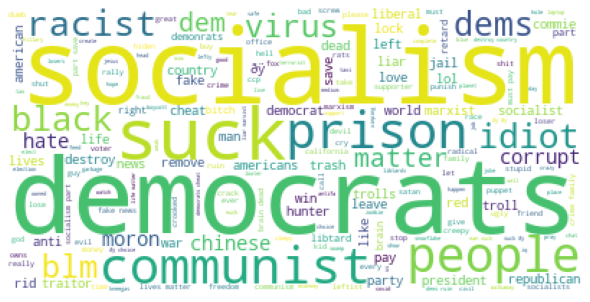

Sexual Harassment


<Figure size 432x288 with 0 Axes>

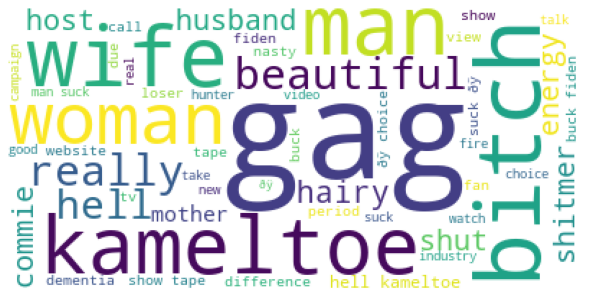

Trolling


<Figure size 432x288 with 0 Axes>

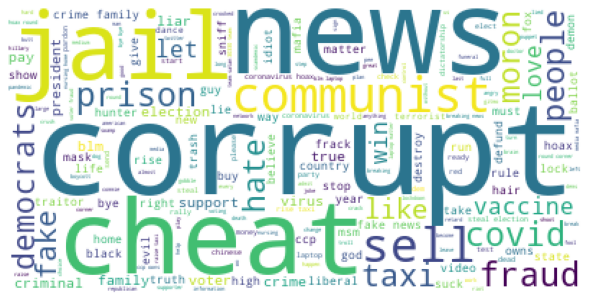

Others


<Figure size 432x288 with 0 Axes>

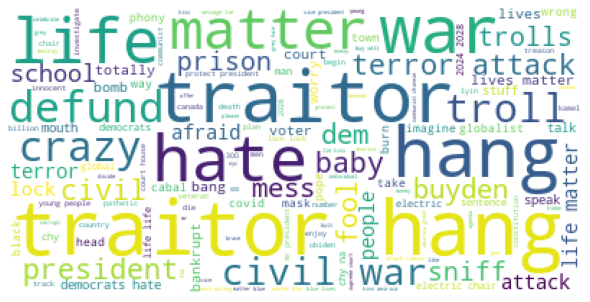

Toxic


<Figure size 432x288 with 0 Axes>

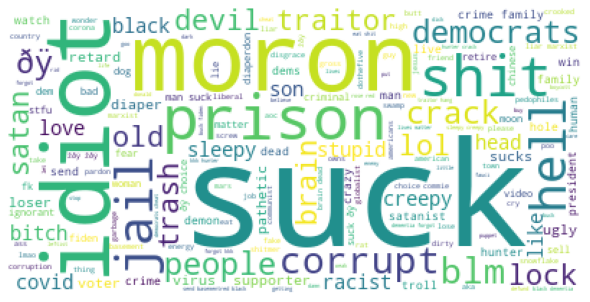

<Figure size 432x288 with 0 Axes>

In [133]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

src_folder = "tfidf_scores_WORDS_per_video_2/"
dest_folder = "tfidf_scores_WORDS_per_video_2/WORD_CLOUD_"
top_dfs = []
for file in genre_files:
    vals = {}
    df = pd.read_csv(src_folder+file, index_col = 0)
    features = df.columns.difference(labels)
    print(file)
    for label in labels:
        print(label)
        dl = df[df[label] == 1 ].drop(columns=labels)
        Cloud = WordCloud(background_color="white").generate_from_frequencies( dl.T.sum(axis=1))
        plt.figure(figsize = (8, 8), facecolor = None)
        plt.imshow(Cloud)
        plt.axis("off")
        plt.tight_layout(pad = 0)
        plt.show()
        f = file.split(".csv")[0]
        plt.savefig(dest_folder + label + f + ".png",dpi = 300)
        

In [134]:
labels_ = ["Direct Harassment", "Hate Speech","Sexual Harassment","Trolling", "Others"]
src_folder = "../Annotations/CSVs/"
toxic = "Toxic"
files = genre_files
for file in files:
    print("----------------------------------")
    df = pd.read_csv(src_folder + file)
    print(f"{file}")
    print("----------------------------------")
    for label in labels_:
        t = df[(df[toxic] == 1) ].shape[0]
        d = df[(df[label] == 1) ].shape[0]
        t_d = df[(df[toxic] == 1) & (df[label] == 1)].shape[0]
        print(f"{t_d} /{d}\t\t{label}")

----------------------------------


C:\Users\Phoebe\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3418: DtypeWarning: Columns (11,12,14,17) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


gaming_channels_GENRE.csv
----------------------------------
12 /70		Direct Harassment
6 /126		Hate Speech
1 /13		Sexual Harassment
1 /43		Trolling
1 /5		Others
----------------------------------
news_channel_GENRE.csv
----------------------------------
127 /566		Direct Harassment
153 /802		Hate Speech
7 /26		Sexual Harassment
52 /483		Trolling
28 /75		Others


gaming_channels_GENRE.csv
Direct Harassment
58 /70		Direct Harassment only


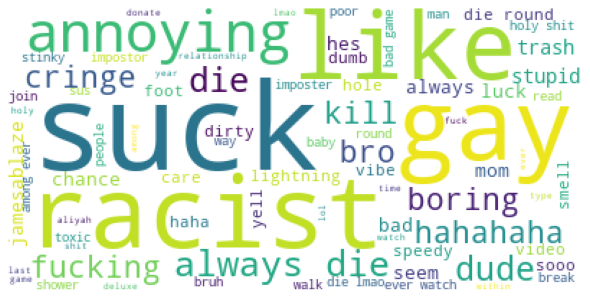

12 /70		 Toxic and Direct Harassment


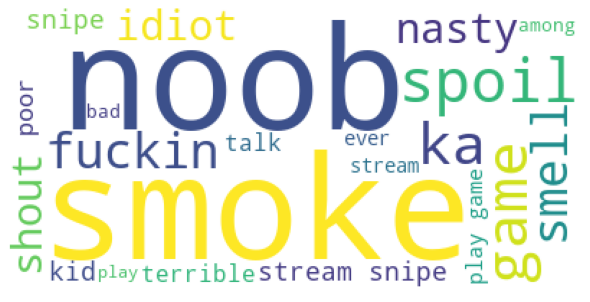

Hate Speech
120 /126		Hate Speech only


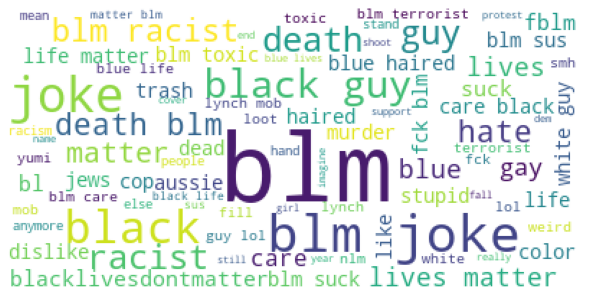

6 /126		 Toxic and Hate Speech


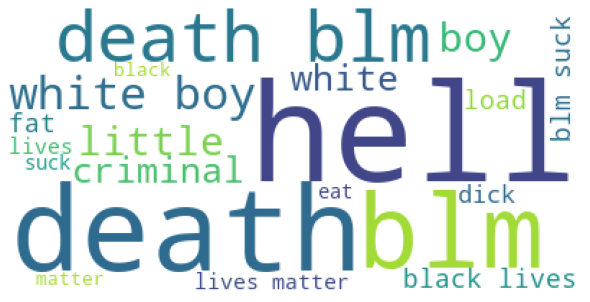

Sexual Harassment
12 /13		Sexual Harassment only


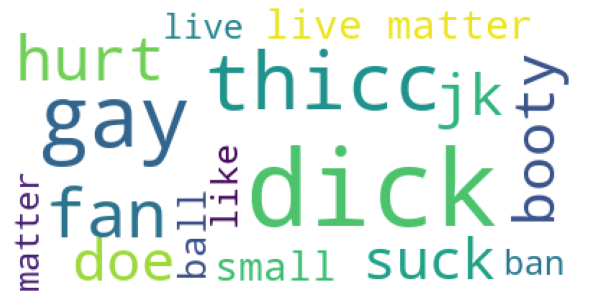

1 /13		 Toxic and Sexual Harassment


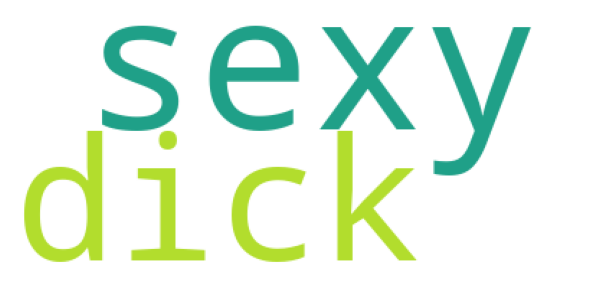

Trolling
42 /43		Trolling only


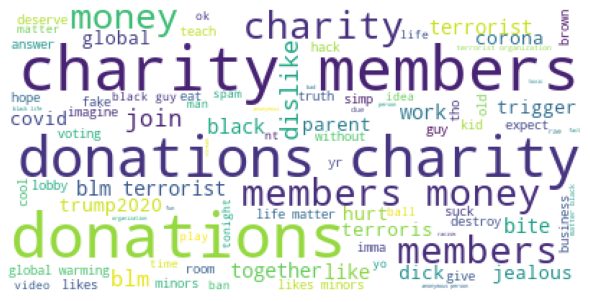

1 /43		 Toxic and Trolling


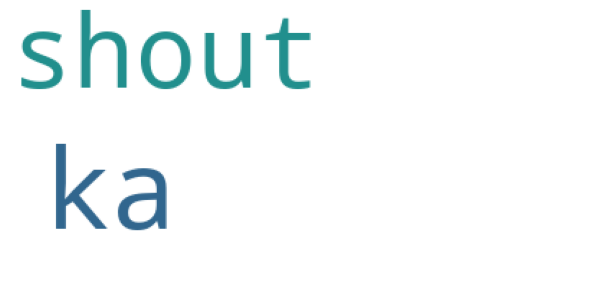

Others
4 /5		Others only


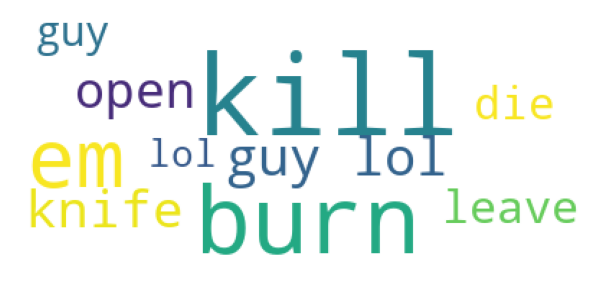

1 /5		 Toxic and Others


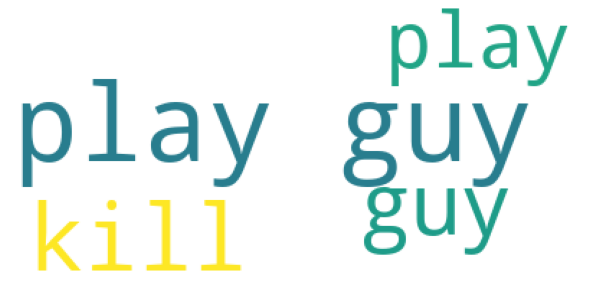

Toxic
51 /51		 Toxic and Toxic


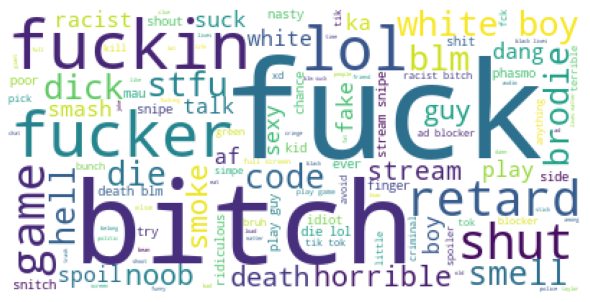

news_channel_GENRE.csv
Direct Harassment
439 /566		Direct Harassment only


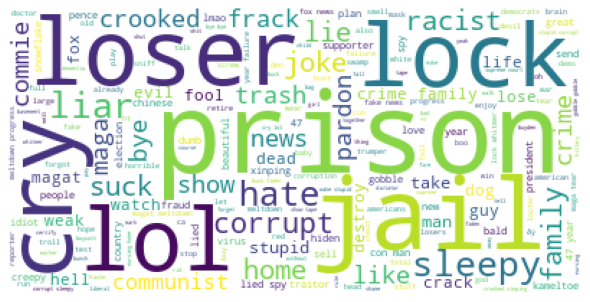

127 /566		 Toxic and Direct Harassment


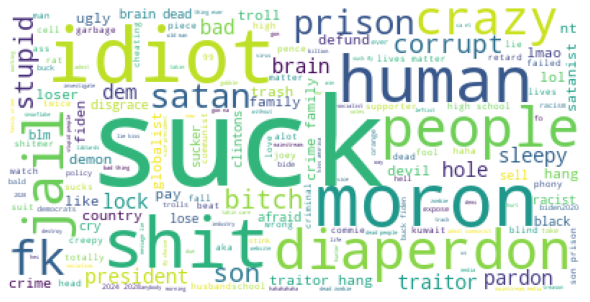

Hate Speech
649 /802		Hate Speech only


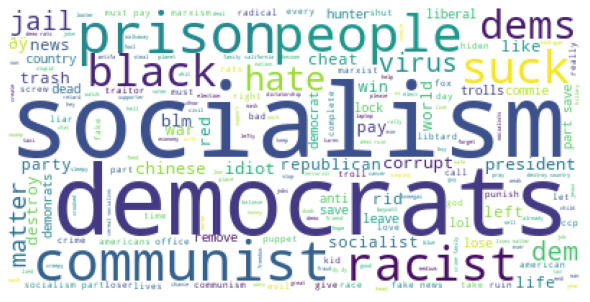

153 /802		 Toxic and Hate Speech


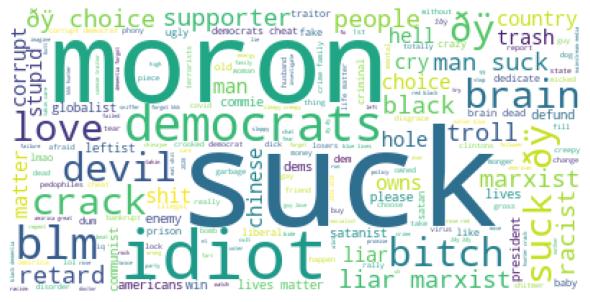

Sexual Harassment
19 /26		Sexual Harassment only


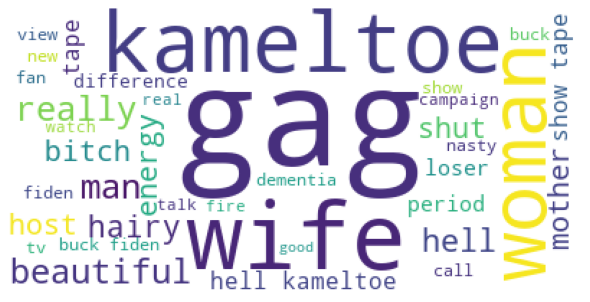

7 /26		 Toxic and Sexual Harassment


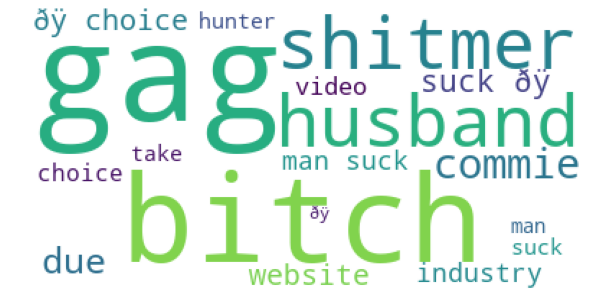

Trolling
431 /483		Trolling only


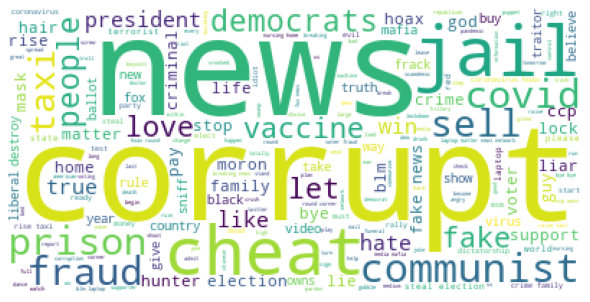

52 /483		 Toxic and Trolling


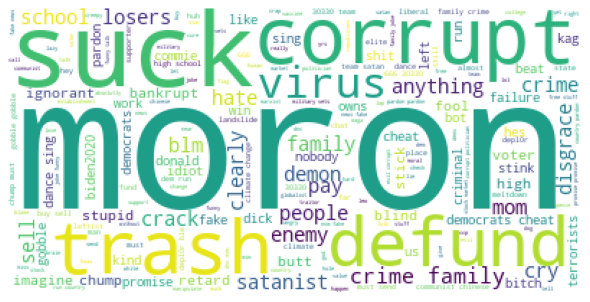

Others
47 /75		Others only


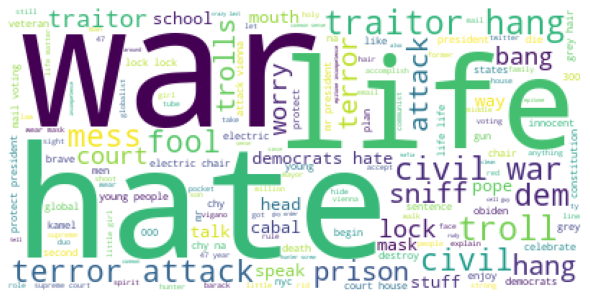

28 /75		 Toxic and Others


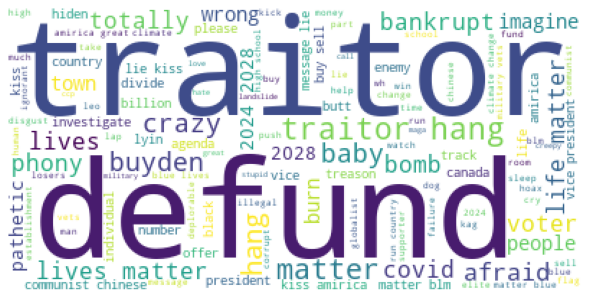

Toxic
436 /436		 Toxic and Toxic


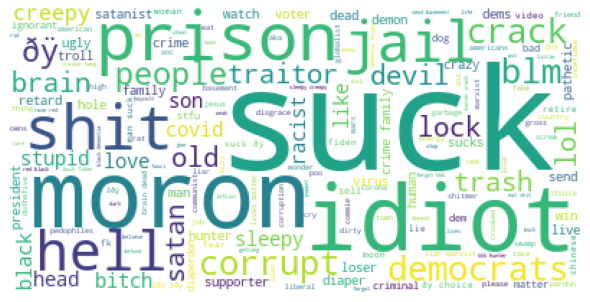

In [135]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

src_folder = "tfidf_scores_WORDS_per_video_2/"
top_dfs = []
for file in genre_files:
    vals = {}
    df = pd.read_csv(src_folder+file, index_col = 0)
    print(file)
    for label in labels:
        print(label)
        dl = df[ (df[label] == 1) &  (df["Toxic"] == 0)  ].drop(columns=labels)
        dx = df[ (df[label] == 1) &  (df["Toxic"] == 1)  ].drop(columns=labels)
        t = df[(df["Toxic"] == 1) &  (df[label] == 1)].shape[0]
        d = df[(df[label] == 1) & (df["Toxic"] == 0) ].shape[0]
        total = df[(df[label] == 1)].shape[0]
        
        if label != 'Toxic':
            print(f"{d} /{total}\t\t{label} only")
            Cloud = WordCloud(background_color="white").generate_from_frequencies( dl.T.sum(axis=1))
            plt.figure(figsize = (8, 8), facecolor = None)
            plt.imshow(Cloud)
            plt.axis("off")
            plt.tight_layout(pad = 0)
            plt.show()
        if t > 0:
            print(f"{t} /{total}\t\t Toxic and {label}" )
            Cloud2 = WordCloud(background_color="white").generate_from_frequencies( dx.T.sum(axis=1))
            plt.figure(figsize = (8, 8), facecolor = None)
            plt.imshow(Cloud2)
            plt.axis("off")
            plt.tight_layout(pad = 0)
            plt.show()

In [136]:
labels_ = ["Direct Harassment", "Hate Speech","Sexual Harassment","Trolling", "Others"]
src_folder = "../Annotations/CSVs/"
toxic = "Toxic"
files = genre_files
for file in files:
    print("----------------------------------")
    df = pd.read_csv(src_folder + file)
    print(f"{file}")
    print("----------------------------------")
    sums = []
    for label in labels_:
        t = df[(df[toxic] == 1) ].shape[0]
        d = df[(df[toxic] == 1) & (df[label] == 1) ].shape[0]
        sums.append(d)
        print(f"{d} /{t}\t\t{toxic} is labeled as {label}")
    total = sum(sums)
    print( f"\n{total} /{t}\t\tToxic is labeled along with other labels" )
    print( f"{t - total} /{t}\t\tToxic is not labeled along with others\n" )

----------------------------------
gaming_channels_GENRE.csv
----------------------------------
12 /51		Toxic is labeled as Direct Harassment
6 /51		Toxic is labeled as Hate Speech
1 /51		Toxic is labeled as Sexual Harassment
1 /51		Toxic is labeled as Trolling
1 /51		Toxic is labeled as Others

21 /51		Toxic is labeled along with other labels
30 /51		Toxic is not labeled along with others

----------------------------------
news_channel_GENRE.csv
----------------------------------
127 /436		Toxic is labeled as Direct Harassment
153 /436		Toxic is labeled as Hate Speech
7 /436		Toxic is labeled as Sexual Harassment
52 /436		Toxic is labeled as Trolling
28 /436		Toxic is labeled as Others

367 /436		Toxic is labeled along with other labels
69 /436		Toxic is not labeled along with others



gaming_channels_GENRE.csv
Toxic Words in Harassment Labels


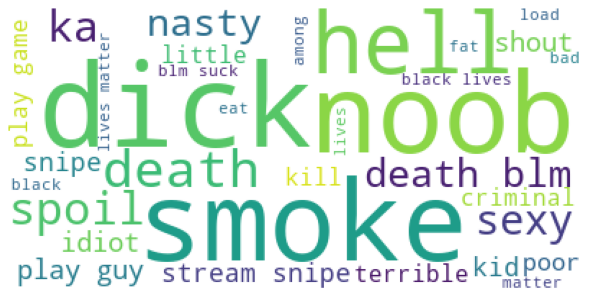

Toxic Words not in Harassment Labels


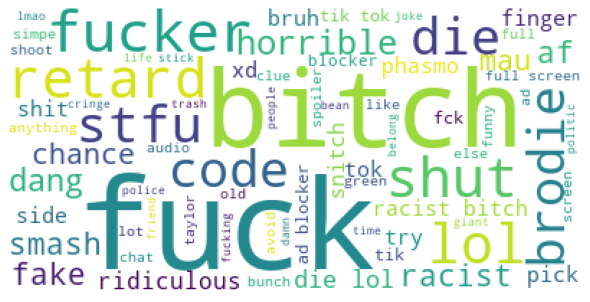

Toxic + Harassment Labels  Toxic only
dick                     1.085687         NaN
smoke                    1.000000         NaN
noob                     1.000000         NaN
hell                     1.000000         NaN
death                    0.919983         NaN
...                           ...         ...
people                        NaN    0.258115
stick                         NaN    0.246703
trash                         NaN    0.238164
cringe                        NaN    0.214767
friend                        NaN    0.196437

[105 rows x 2 columns]

news_channel_GENRE.csv
Toxic Words in Harassment Labels


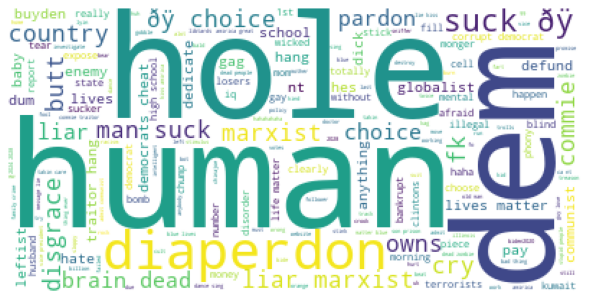

Toxic Words not in Harassment Labels


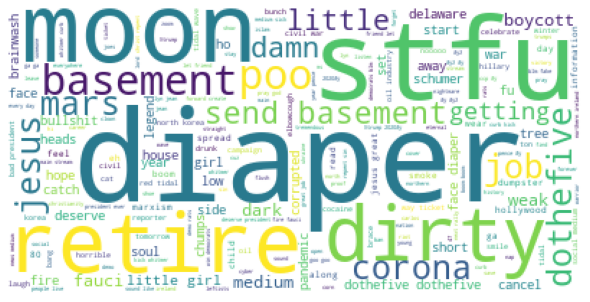

Toxic + Harassment Labels  Toxic only
human                         2.218016         NaN
hole                          2.214494         NaN
dem                           2.074582         NaN
diaperdon                     1.974283         NaN
suck ðÿ                       1.874416         NaN
...                                ...         ...
anywhere                           NaN    0.213558
belong                             NaN    0.209958
white house                        NaN    0.179316
mask                               NaN    0.053164
states                             NaN    0.051722

[586 rows x 2 columns]

In [137]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
labels_ = ["Direct Harassment", "Hate Speech","Sexual Harassment","Trolling", "Others"]

src_folder = "tfidf_scores_WORDS_per_video_2/"
top_dfs = []
for file in genre_files:
    vals = {}
    dfs = []
    df = pd.read_csv(src_folder+file, index_col = 0)
    print(file)
    
    dl = df[ ( (df[labels_[0]] == 1) | (df[labels_[1]] == 1) | (df[labels_[2]] == 1) | (df[labels_[3]] == 1) | 
              (df[labels_[4]] == 1)) &  (df["Toxic"] == 1)  ].drop(columns=labels)
    
    dx = df[ ( df[labels_[0]] == 0) & (df[labels_[1]] == 0) & (df[labels_[2]] == 0) & (df[labels_[3]] == 0) & 
              (df[labels_[4]] == 0) &  (df["Toxic"] == 1)  ].drop(columns=labels)
    
    
    
    #print("Toxic Words in Harassment Labels")
    l = pd.DataFrame(dl.T.sum(axis=1))
    l = l[l[0]>0].sort_values(by = 0, ascending = False)
    l_new = l.rename({0: 'Toxic + Harassment Labels'},  axis='columns')
    l_new.index.name = "Toxic + Harassment"
    dfs.append(l_new)
                     
   # print("Toxic Words not in Harassment Labels")
    x = pd.DataFrame(dx.T.sum(axis=1))
    x = x[x[0]>0].sort_values(by = 0, ascending = False)
    x_new = x.rename({0: 'Toxic only'}, axis='columns')
    x_new.index.name = "Toxic only"
    dfs.append(x_new)
    
    dn = pd.concat(dfs, axis = 1)
    dn = dn[dn.isnull().any(axis=1)]
    
    Cloud = WordCloud(background_color="white").generate_from_frequencies( dn['Toxic + Harassment Labels'].dropna())
    Cloud2 = WordCloud(background_color="white").generate_from_frequencies( dn['Toxic only'].dropna())
    
    print("Toxic Words in Harassment Labels")
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(Cloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.show()
    
    print("Toxic Words not in Harassment Labels")
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(Cloud2)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.show()
    
    display(dn)
    
    